### Load in modules

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import cascaded_union
from shapely.geometry import JOIN_STYLE
import matplotlib.pyplot as plt
import matplotlib.colors as colors


### Load in shapefile

In [2]:
uk_map = gpd.read_file('./Data/shp/shapefile_out.shp')
uk_map = uk_map.to_crs('epsg:3395')


### Load in LTLA <-> region map

In [3]:
ltla_region = pd.read_csv('./Data/LTLA-region_lookup_corrected.csv', sep=',')
ltla_region.head()


,la_code,la_name,region_code,region_name,Unnamed: 4
0,E06000001,Hartlepool,E12000001,North East,NaN
1,E06000002,Middlesbrough,E12000001,North East,NaN
2,E06000003,Redcar and Cleveland,E12000001,North East,NaN
3,E06000004,Stockton-on-Tees,E12000001,North East,NaN
4,E06000005,Darlington,E12000001,North East,NaN


#### Extract only London/South East regions

In [4]:
ldn_ltlas = ltla_region[ltla_region.region_name == 'London'].la_code.values
se_ltlas = ltla_region[ltla_region.region_name == 'South East'].la_code.values
ee_ltlas = ltla_region[ltla_region.region_name == 'East'].la_code.values


In [5]:
ldn_map = uk_map[uk_map.geo_code.isin(ldn_ltlas)]
ldn_map_dissolved = gpd.GeoDataFrame(
    [(1, gpd.GeoSeries(cascaded_union(ldn_map.geometry.values)).geometry.unary_union.buffer(
        1000, 1, join_style=JOIN_STYLE.mitre).buffer(
        -1000, 1, join_style=JOIN_STYLE.mitre))], columns=['id', 'geometry'])

se_map = uk_map[uk_map.geo_code.isin(se_ltlas)]
se_map_dissolved = gpd.GeoDataFrame(
    [(1, gpd.GeoSeries(cascaded_union(se_map.geometry.values)).geometry.unary_union.buffer(
        3000, 1, join_style=JOIN_STYLE.mitre).buffer(
        -3000, 1, join_style=JOIN_STYLE.mitre))], columns=['id', 'geometry'])

ee_map = uk_map[uk_map.geo_code.isin(ee_ltlas)]
ee_map_dissolved = gpd.GeoDataFrame(
    [(1, gpd.GeoSeries(cascaded_union(ee_map.geometry.values)).geometry.unary_union.buffer(
        2000, 1, join_style=JOIN_STYLE.mitre).buffer(
        -2000, 1, join_style=JOIN_STYLE.mitre))], columns=['id', 'geometry'])


### Load in epi-peaks output

In [7]:
epi_peaks = pd.read_csv('./Data/LTLA_BA.1_case_incidence_peaks.csv', sep=',')
epi_peaks.head()


,origin,peak_LL.date,peak_UL.date,peak_mid.date,relative_to_dec,relative_to_christmas
0,E09000001,2021-12-14,2021-12-18,2021-12-16,15.0,before
1,E09000012,2021-12-15,2021-12-20,2021-12-17,16.5,before
2,E09000032,2021-12-15,2021-12-20,2021-12-17,16.5,before
3,E09000007,2021-12-15,2021-12-21,2021-12-18,17.0,before
4,E09000019,2021-12-15,2021-12-21,2021-12-18,17.0,before


### Make plot

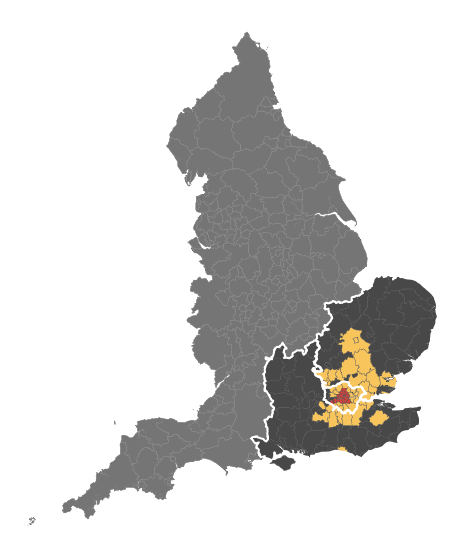

In [15]:
w = 10; h = 10
fig, ax = plt.subplots(figsize=(w, h))

colours = ['#484848','#D43F3A', '#F8C55D']

uk_plot = pd.merge(uk_map, epi_peaks, left_on='geo_code', right_on='origin')
uk_plot = uk_plot.plot(ax=ax, column='relative_to_christmas', fc='.95', ec='#484848',
                       cmap=colors.ListedColormap(colours),
                       linewidth=0.3, alpha=1, legend=False)

uk_map[~uk_map.geo_code.isin(ldn_ltlas.tolist() + se_ltlas.tolist() + ee_ltlas.tolist())].plot(
    ax=ax, fc='white', ec='white',
    linewidth=0.1, alpha=0.25, legend=False)

ldn_map_dissolved.plot(ax=ax, fc='none', ec='white', lw=1.5)
se_map_dissolved.plot(ax=ax, fc='none', ec='white', lw=2)
ee_map_dissolved.plot(ax=ax, fc='none', ec='white', lw=2)

uk_map[uk_map.geo_code == 'E06000046'].plot(
    ax=ax, fc='#484848', ec='#484848',
    linewidth=0.3, alpha=1, legend=False)

uk_plot.set_rasterized(True)

ax.set_axis_off()

plt.savefig('epi_peaks_map_v3.pdf', dpi=300)
